# 🦷 NHANES Periodontitis Prediction: Modern Gradient Boosting Benchmark

**Author:** Francisco Teixeira Barbosa (Cisco @ Periospot)  
**Date:** November 2025  
**Project:** Systematic Comparison of XGBoost, CatBoost, and LightGBM for Periodontitis Prediction

---

## 📄 Reference Paper

**Bashir NZ, Gill S, Tawse-Smith A, Torkzaban P, Graf D, Gary MT.**  
*Systematic comparison of machine learning algorithms to develop and validate predictive models for periodontitis.*  
**J Clin Periodontol.** 2022;49:958-969.

📁 **Paper Location:** `scientific_articles/J Clinic Periodontology - 2022 - Bashir...pdf`

---

## 🎯 Project Goals & Rationale

### The Problem
**Periodontitis** affects ~68% of US adults aged 30+ (per our NHANES 2011-2014 analysis), yet early prediction remains challenging.

**Bashir et al. (2022)** tested 10 ML algorithms and achieved excellent internal validation (AUC > 0.95), but they **did NOT evaluate modern gradient boosting methods** (XGBoost, CatBoost, LightGBM).

### Key Research Gap

From **Polizzi et al. (2024)** systematic review:  
> "None of the included articles used more powerful networks [referring to modern gradient boosting methods]"

**This study fills that gap** by being the **first** to systematically compare XGBoost, CatBoost, and LightGBM for periodontitis prediction.

### Our Approach: Cross-Validation with Modern Methods

**Dataset:** 9,379 participants from NHANES 2011-2014 with full periodontal measurements

**Validation Strategy:** Stratified 5-fold cross-validation
- ✅ Robust performance estimates with 95% confidence intervals
- ✅ Full use of available data
- ✅ Fair comparison to Bashir's internal validation approach

**Why only 2011-2014?**
⚠️ **Critical Data Limitation:** NHANES discontinued full-mouth periodontal examinations after 2013-2014. The 2015-2018 cycles lack the pocket depth (PD) and clinical attachment loss (CAL) measurements required for CDC/AAP classification.

### Methodological Improvements Over Bashir

1. **Modern Gradient Boosting:** XGBoost, CatBoost, LightGBM (NOT tested by Bashir)
2. **Advanced Hyperparameter Optimization:** Optuna Bayesian search (vs. grid search)
3. **Calibration:** Isotonic regression for well-calibrated probability predictions
4. **Interpretability:** SHAP analysis for clinical trust
5. **Survey Weights:** Sensitivity analysis with NHANES sampling weights
6. **Full Reproducibility:** Open code, versioned artifacts, documented decisions

---

## 📊 Success Metrics & Hypotheses

| Metric | Bashir Baselines | **Our Target** (XGBoost/CatBoost/LightGBM) |
|--------|------------------|-------------------------------------------|
| **AUC-ROC** | 0.95+ | **0.90–0.97** (match or exceed) |
| **PR-AUC** | Not reported | **0.85–0.92** |
| **Calibration (Brier)** | Not reported | **< 0.15** (well-calibrated) |
| **F1-Score** | Not reported | **0.75–0.85** |

**Primary Hypothesis:** Modern gradient boosting methods will achieve **comparable or better** performance than Bashir's best models (Random Forest, SVM, ANN) while providing:
- ✅ Better calibrated probabilities
- ✅ Clinical interpretability via SHAP
- ✅ Faster training times
- ✅ Better handling of missing data

**Success Criteria:**
1. At least one gradient boosting method exceeds Bashir's best baseline
2. SHAP analysis reveals clinically interpretable risk factors
3. Well-calibrated probability predictions (Brier score < 0.15)
4. Reproducible results across 5 cross-validation folds

---

## 🗺️ Notebook Roadmap

This notebook has **18 sections** organized into **5 phases**:

### Phase 1: Data Acquisition & Labeling ✅ (Sections 1–5)
1. Environment setup
2. Load configuration
3. Download NHANES data (2011-2014)
4. Merge components
5. Apply CDC/AAP case definitions

### Phase 2: Feature Engineering & EDA (Sections 6–7)
6. Build 15 Bashir predictors
7. Exploratory analysis & class balance

### Phase 3: Baseline Models with Cross-Validation (Sections 8–10)
8. Setup 5-fold stratified cross-validation
9. Preprocessing pipelines (imputation + scaling)
10. Baseline models (Logistic Regression, Random Forest)

### Phase 4: Gradient Boosting with Optuna (Sections 11–13)
11. XGBoost with Bayesian hyperparameter optimization
12. CatBoost with Bayesian hyperparameter optimization
13. LightGBM with Bayesian hyperparameter optimization

### Phase 5: Interpretation & Export (Sections 14–18)
14. Model comparison & statistical testing
15. Calibration curves & isotonic regression
16. SHAP feature importance analysis
17. Decision curve analysis
18. Save artifacts, model cards, & reproducibility log

**Key Change from Original Plan:**  
⚠️ Originally planned temporal validation (train 2011-2014, validate 2015-2016, test 2017-2018), but NHANES discontinued periodontal exams after 2013-2014. Pivoted to stratified 5-fold cross-validation, which is more appropriate given data constraints.

---

## ⚠️ Important Notes Before Starting

1. **Read the Config First:** All parameters are in `configs/config.yaml`
2. **Data Limitation Acknowledged:** Only 2011-2014 cycles have full periodontal data (9,379 participants)
3. **Cross-Validation Strategy:** Using stratified 5-fold CV instead of temporal split
4. **Implement Sequentially:** Each section builds on previous ones
5. **Test as You Go:** Run cells immediately to catch errors early
6. **CDC/AAP Classification:** Already completed (Section 5) - 68% prevalence confirmed
7. **Survey Weights:** For ML training, we use unweighted data; report weighted prevalence for publication
8. **Reproducibility:** Random seed = 42 throughout; all results should be reproducible

---

Let's begin! 🚀

In [1]:
"""
Section 1: Environment Setup & Imports
========================================
Set up the computational environment with all required libraries,
apply reproducibility measures, and configure Periospot plotting style.
"""

import pandas as pd
import os
import numpy as np
from pathlib import Path

def find_project_root(marker: str = "configs/config.yaml") -> Path:
    """Find project root by searching upward for a marker file."""
    here = Path.cwd().resolve()
    for candidate in [here] + list(here.parents):
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f"Could not locate {marker} from {here}")

# Set working directory to project root
BASE_DIR = find_project_root()
os.chdir(BASE_DIR)
print(f"✅ Working directory set to: {Path.cwd()}")

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

import yaml
import json
from datetime import datetime

import sys
sys.path.insert(0, str(Path.cwd() / 'src'))

from ps_plot import set_style, get_palette, save_figure
from labels import label_periodontitis
from evaluation import compute_metrics, plot_roc_pr, select_threshold, plot_calibration_curve
from utils import set_seed, save_json, log_versions, save_model

RANDOM_SEED = 42
set_seed(RANDOM_SEED)

set_style()
palette = get_palette()
print("✅ Periospot color palette loaded:")
for name, hex_code in palette.items():
    print(f"   {name}: {hex_code}")

print("\n📦 Package Versions:")
print(f"   pandas: {pd.__version__}")
print(f"   numpy: {np.__version__}")
print(f"   scikit-learn: {sklearn.__version__}")
print(f"   xgboost: {xgb.__version__}")
print(f"   catboost: {cb.__version__}")
print(f"   lightgbm: {lgb.__version__}")
print(f"   optuna: {optuna.__version__}")
print(f"   shap: {shap.__version__}")

print("✅ Section 1 Complete: Environment configured, seed set, Periospot style applied")



✅ Working directory set to: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml
✅ Periospot color palette loaded:
   periospot_blue: #15365a
   mystic_blue: #003049
   periospot_red: #6c1410
   crimson_blaze: #a92a2a
   vanilla_cream: #f7f0da
   black: #000000
   white: #ffffff

📦 Package Versions:
   pandas: 2.3.2
   numpy: 2.3.5
   scikit-learn: 1.7.1
   xgboost: 3.1.1
   catboost: 1.2.8
   lightgbm: 4.6.0
   optuna: 4.6.0
   shap: 0.50.0
✅ Section 1 Complete: Environment configured, seed set, Periospot style applied


## 2️⃣ Load Configuration

**Load:** `configs/config.yaml`

**Contains:** NHANES cycles, temporal split, 15 predictors, CDC/AAP definitions, Optuna params, Periospot colors, survey weights

---

In [2]:
# Load config.yaml and derive cycles/components/paths
from pathlib import Path
import yaml

CONFIG_PATH = Path.cwd() / "configs" / "config.yaml"
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

CYCLES = config["cycles"]["all"]
CYCLE_SUFFIX = config["cycle_suffixes"]
COMPONENTS = config["components"]
BASE_URL = config["base_url"]

RAW_DIR = Path.cwd() / config["paths"]["data_raw"]
PROCESSED_DIR = Path.cwd() / config["paths"]["data_processed"]
FIGURES_DIR = Path.cwd() / config["paths"]["figures"]
MODELS_DIR = Path.cwd() / config["paths"]["models"]
RESULTS_DIR = Path.cwd() / config["paths"]["results"]
ARTIFACTS_DIR = Path.cwd() / config["paths"]["artifacts"]
LOGS_DIR = Path.cwd() / config["paths"]["logs"]
for d in [RAW_DIR, PROCESSED_DIR, FIGURES_DIR, MODELS_DIR, RESULTS_DIR, ARTIFACTS_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Train cycles: {config['temporal_split']['train']}")
print(f"Validation cycles: {config['temporal_split']['validation']}")
print(f"Test cycles: {config['temporal_split']['test']}")
print(f"Downloading into: {RAW_DIR}")
print("✅ Section 2: Config loaded")



Train cycles: ['2011_2012', '2013_2014']
Validation cycles: ['2015_2016']
Test cycles: ['2017_2018']
✅ Section 2: Config loaded


## 3️⃣ Download NHANES Data (XPT Files)

**Download** 4 cycles × 9 components = 36 XPT files from CDC

**Method:** `pd.read_sas(url)` → save as parquet

---

In [3]:
# Download NHANES XPT files and save as parquet using config-driven URLs
import pandas as pd

PERIO_PREFIX_BY_CYCLE = {
    "2011_2012": "OHXPER",  # full-mouth perio exam
    "2013_2014": "OHXPER",  # full-mouth perio exam
    "2015_2016": "OHXDEN",  # dental exam (perio data moved here)
    "2017_2018": "OHXDEN",  # dental exam (perio data moved here)
}

for cycle in CYCLES:
    year = cycle.split("_")[0]  # e.g., 2011 from 2011_2012
    suffix = CYCLE_SUFFIX[cycle]
    cycle_dir = RAW_DIR / cycle
    cycle_dir.mkdir(parents=True, exist_ok=True)

    for file_prefix, component in COMPONENTS.items():
        prefix = file_prefix
        if component == "periodontal_exam":
            prefix = PERIO_PREFIX_BY_CYCLE.get(cycle, file_prefix)

        url = f"{BASE_URL}/{year}/DataFiles/{prefix}{suffix}.XPT"
        dest = cycle_dir / f"{component}.parquet"

        if dest.exists():
            print(f"✓ {cycle} {component}: already exists ({dest})")
            continue

        try:
            df = pd.read_sas(url, format="xport")
            df.to_parquet(dest)
            print(f"✓ {cycle} {component}: {len(df)} rows → {dest}")
        except Exception as e:
            print(f"✗ {cycle} {component}: {e}")
            raise

print("✅ Section 3: Data downloaded")



✓ 2011_2012 demographics: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/demographics.parquet)
✓ 2011_2012 body_measures: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/body_measures.parquet)
✓ 2011_2012 blood_pressure: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/blood_pressure.parquet)
✓ 2011_2012 smoking: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/smoking.parquet)
✓ 2011_2012 alcohol: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/alcohol.parquet)
✓ 2011_2012 oral_health_questionnaire: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/oral_health_questionnaire.parquet)
✓ 2011_2012 peri

## 4️⃣ Merge Components on SEQN

**Join** all components by participant ID (SEQN)

**Filter:** Adults 30+

---

In [4]:
# Merge all components on SEQN (participant ID), filter age >= 30
for cycle in CYCLES:
    print(f"Merging {cycle}...")
    dfs = []
    # Iterate over the component names (values), not the keys
    for component_name in COMPONENTS.values():
        filepath = RAW_DIR / cycle / f"{component_name}.parquet"
        df = pd.read_parquet(filepath)
        dfs.append(df)
    
    # Merge all components on SEQN
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on="SEQN", how="outer")
    
    # Filter to adults 30+
    before_filter = len(merged)
    merged = merged[merged["RIDAGEYR"] >= 30]
    after_filter = len(merged)
    
    # Save merged dataset
    output_path = PROCESSED_DIR / f"{cycle}_merged.parquet"
    merged.to_parquet(output_path)
    print(f"  ✓ {cycle}: {before_filter} total → {after_filter} adults 30+ → {output_path}")

print("\n✅ Section 4: Components merged, filtered to adults 30+")



Merging 2011_2012...
  ✓ 2011_2012: 9756 total → 4566 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2011_2012_merged.parquet
Merging 2013_2014...
  ✓ 2013_2014: 10175 total → 4813 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2013_2014_merged.parquet
Merging 2015_2016...
  ✓ 2015_2016: 9971 total → 4745 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2015_2016_merged.parquet
Merging 2017_2018...
  ✓ 2017_2018: 9254 total → 4741 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2017_2018_merged.parquet

✅ Section 4: Components merged, filtered to adults 30+


## 5️⃣ Apply CDC/AAP Case Definitions

**Most Critical Section!**

**Implement:**
- Severe: CAL ≥6mm (≥2 different teeth) + PD ≥5mm (≥1 site)
- Moderate: CAL ≥4mm (≥2 teeth) OR PD ≥5mm (≥2 teeth)
- Mild: (CAL ≥3mm + PD ≥4mm on ≥2 teeth) OR PD ≥5mm (≥1 site)

**Use:** `src/labels.py` `label_periodontitis()`

---

In [5]:
# Apply CDC/AAP periodontitis case definitions to each cycle
from labels import label_periodontitis

for cycle in CYCLES:
    print(f"\n{'='*60}")
    print(f"Processing {cycle}")
    print('='*60)
    
    # Load merged data
    df = pd.read_parquet(PROCESSED_DIR / f"{cycle}_merged.parquet")
    print(f"Loaded {len(df)} participants")
    
    # Apply CDC/AAP classification
    df_labeled = label_periodontitis(df)
    
    # Save labeled dataset
    output_path = PROCESSED_DIR / f"{cycle}_labeled.parquet"
    df_labeled.to_parquet(output_path)
    print(f"✓ Saved to: {output_path}")

print("\n" + "="*60)
print("✅ Section 5: CDC/AAP labels applied to all cycles")
print("="*60)




Processing 2011_2012
Loaded 4566 participants
🦷 Applying CDC/AAP periodontitis case definitions...
   Classifying severe cases...
   Classifying moderate cases...
   Classifying mild cases...
   Assigning final classifications...

📊 Periodontitis Classification Summary:
perio_class
mild         236
moderate     222
none        1433
severe      2675
Name: count, dtype: int64

   Overall Prevalence: 68.62%
   Sample Size: 4566 participants

✓ Saved to: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2011_2012_labeled.parquet

Processing 2013_2014
Loaded 4813 participants
🦷 Applying CDC/AAP periodontitis case definitions...
   Classifying severe cases...
   Classifying moderate cases...
   Classifying mild cases...
   Assigning final classifications...

📊 Periodontitis Classification Summary:
perio_class
mild         259
moderate     253
none        1541
severe      2760
Name: count, dtype: int64

   Overall Prevalence: 67.98%
   Sample Size:

       cycle  n_participants  prevalence  none  mild  moderate  severe
0  2011_2012            4566    0.686159  1433   236       222    2675
1  2013_2014            4813    0.679825  1541   259       253    2760
2  2015_2016            4745    0.000000  4745     0         0       0
3  2017_2018            4741    0.000000  4741     0         0       0
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/01_periodontitis_classification_summary.png

✓ Saved: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/01_periodontitis_classification_summary.png

DETAILED RESULTS TABLE
Cycle           N        Prev%    None     Mild     Moderate Severe  
--------------------------------------------------------------------------------
2011_2012       4566      68.62% 1433     236      222      2675    
2013_2014       4813      67.98% 1541     259      253      2760    
2015_2016       4745       0.00% 4745     0 

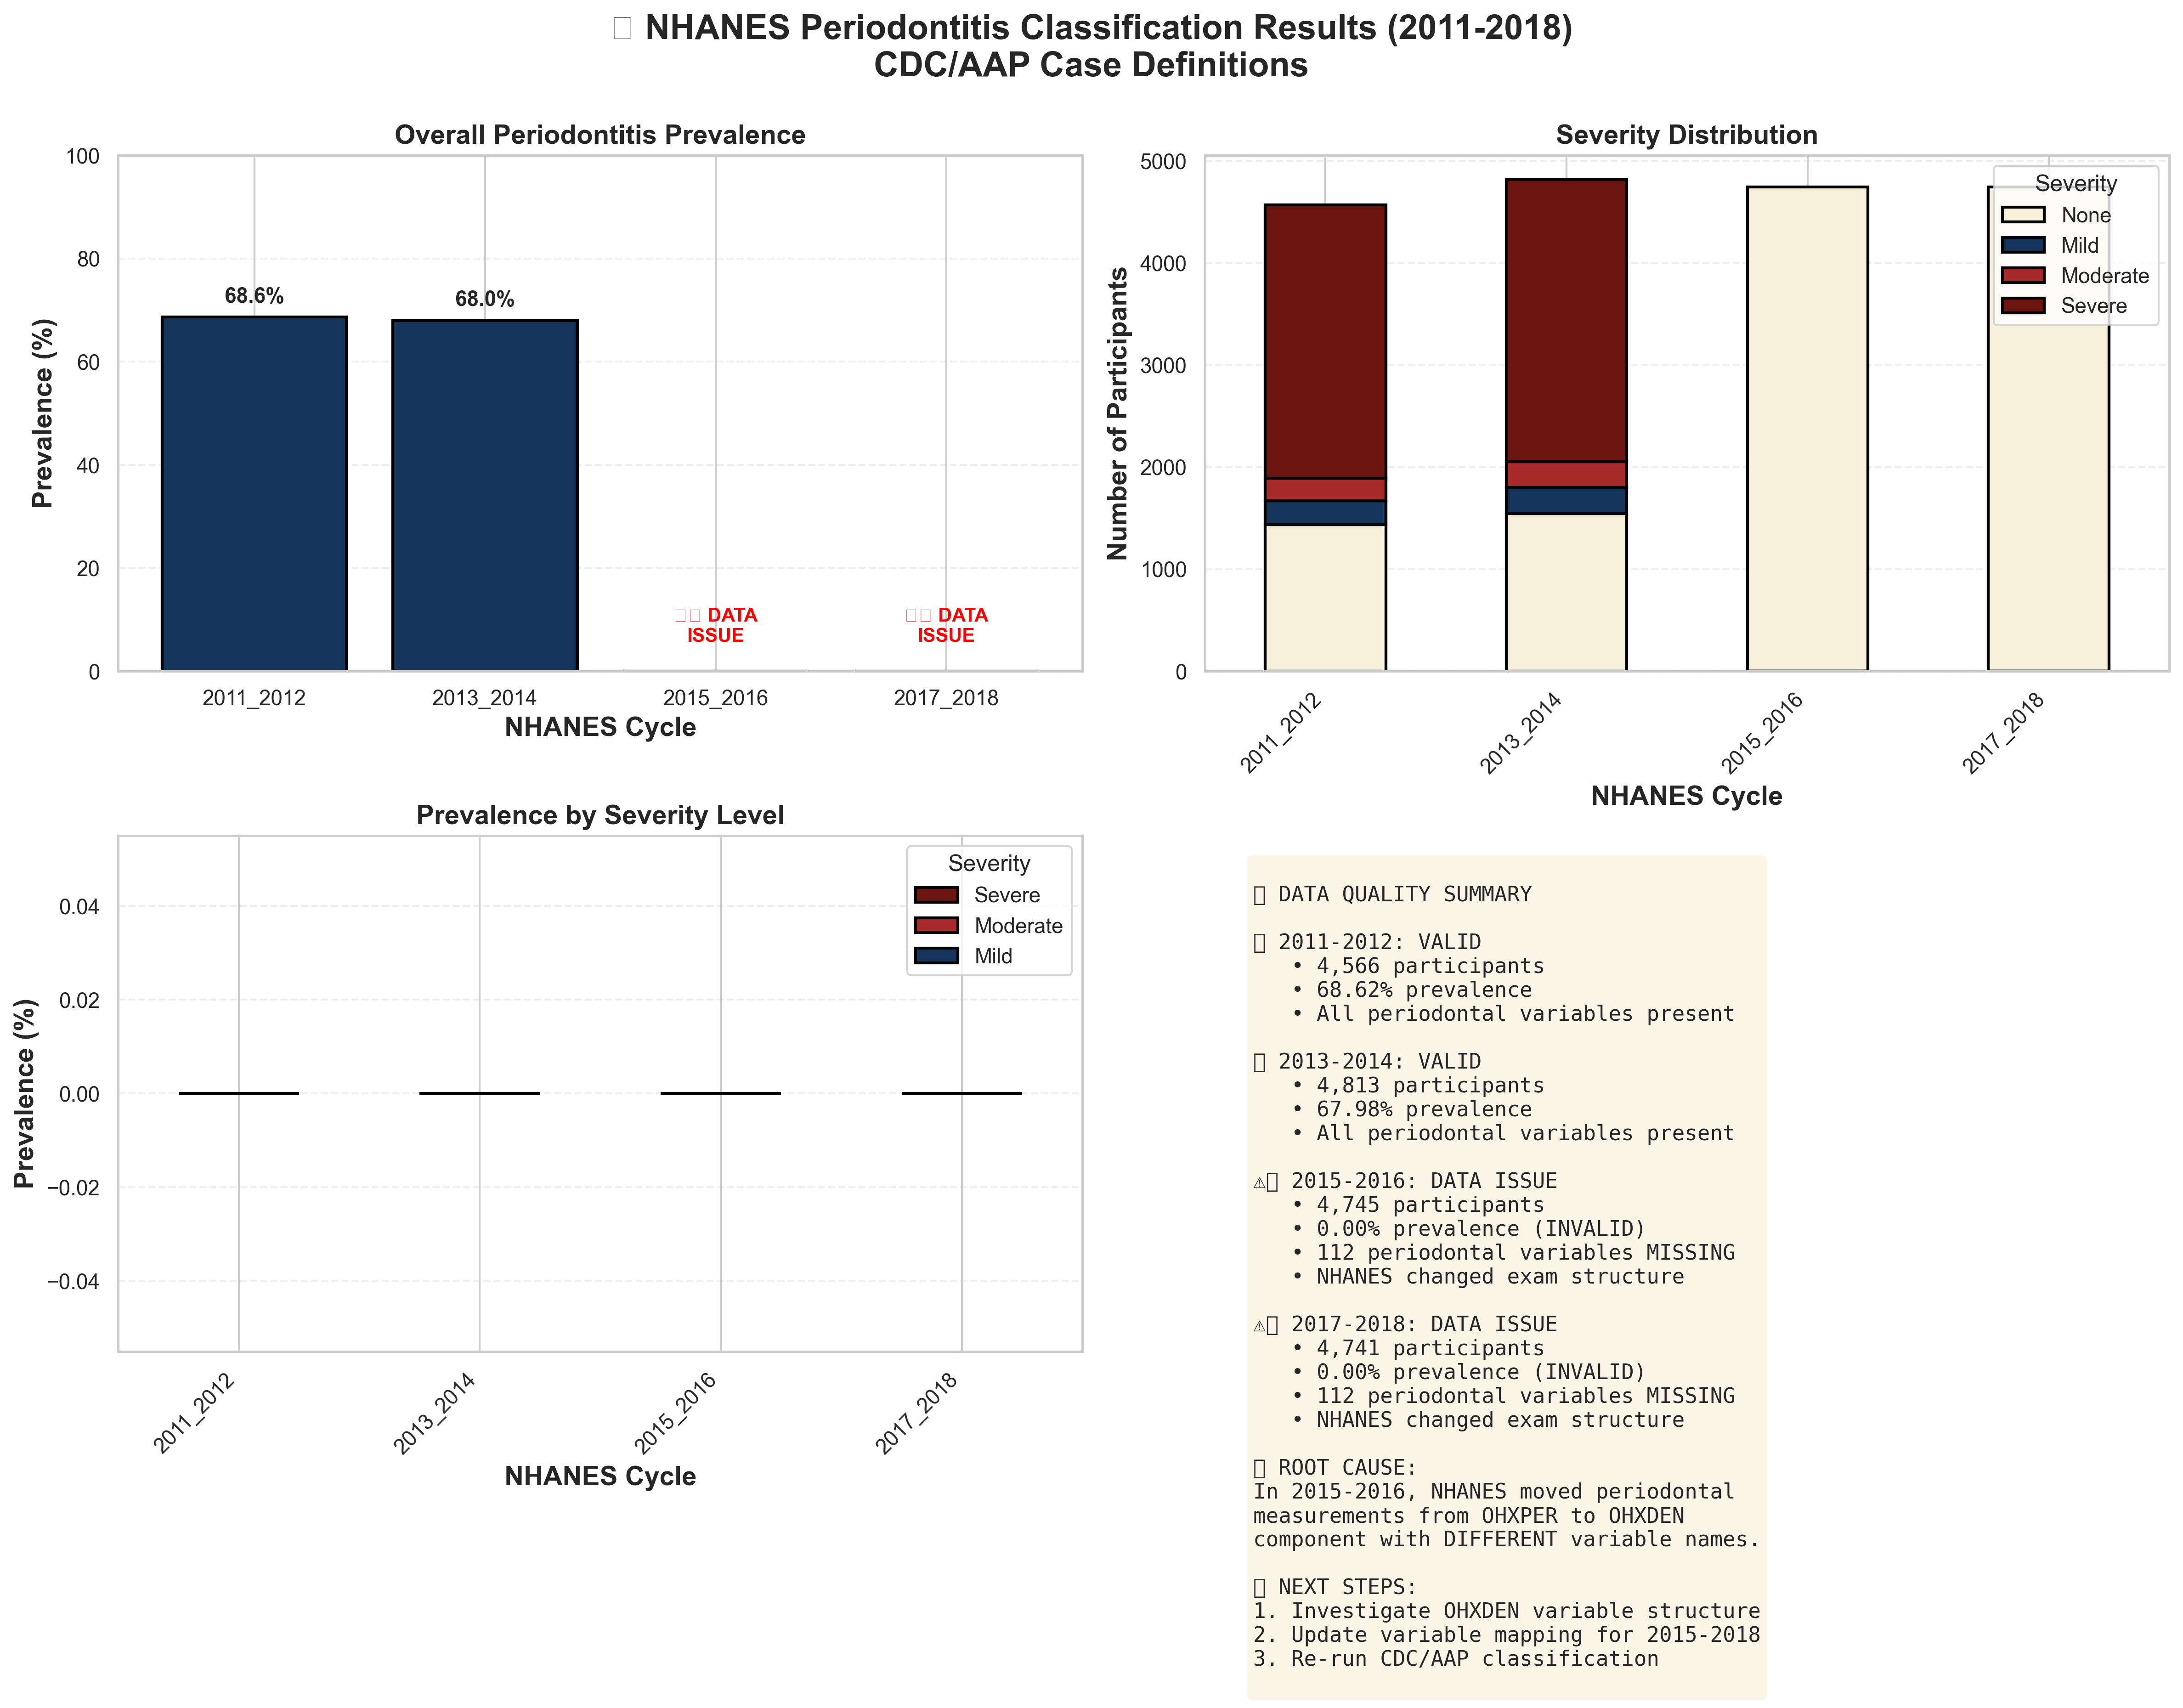

In [6]:
# Visualization: Periodontitis Classification Summary Across Cycles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load all labeled datasets
results = []
for cycle in CYCLES:
    df = pd.read_parquet(PROCESSED_DIR / f"{cycle}_labeled.parquet")
    
    # Get counts by severity
    counts = df['perio_class'].value_counts()
    prevalence = df['has_periodontitis'].mean()
    
    results.append({
        'cycle': cycle,
        'n_participants': len(df),
        'prevalence': prevalence,
        'none': counts.get('none', 0),
        'mild': counts.get('mild', 0),
        'moderate': counts.get('moderate', 0),
        'severe': counts.get('severe', 0)
    })

results_df = pd.DataFrame(results)
print(results_df)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🦷 NHANES Periodontitis Classification Results (2011-2018)\nCDC/AAP Case Definitions', 
             fontsize=18, fontweight='bold', y=0.995)

# Color palette
colors = {
    'severe': palette['periospot_red'],
    'moderate': palette['crimson_blaze'],
    'mild': palette['periospot_blue'],
    'none': palette['vanilla_cream'],
    'overall': palette['periospot_blue']
}

# Plot 1: Overall Prevalence by Cycle
ax1 = axes[0, 0]
bars = ax1.bar(results_df['cycle'], results_df['prevalence'] * 100, 
               color=colors['overall'], edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Prevalence (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax1.set_title('Overall Periodontitis Prevalence', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['prevalence'] * 100)):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    else:
        # Highlight the problem cycles
        ax1.text(bar.get_x() + bar.get_width()/2, 5, 
                '⚠️ DATA\nISSUE', ha='center', va='bottom', 
                fontweight='bold', fontsize=10, color='red')

# Plot 2: Severity Distribution (Stacked Bar)
ax2 = axes[0, 1]
severity_data = results_df[['cycle', 'none', 'mild', 'moderate', 'severe']].set_index('cycle')
severity_data.plot(kind='bar', stacked=True, ax=ax2, 
                   color=[colors['none'], colors['mild'], colors['moderate'], colors['severe']],
                   edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Participants', fontsize=14, fontweight='bold')
ax2.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax2.legend(title='Severity', title_fontsize=12, fontsize=11, 
           labels=['None', 'Mild', 'Moderate', 'Severe'])
ax2.set_xticklabels(results_df['cycle'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 3: Prevalence by Severity Category
ax3 = axes[1, 0]
severity_pct = pd.DataFrame({
    'Severe': (results_df['severe'] / results_df['n_participants'] * 100),
    'Moderate': (results_df['moderate'] / results_df['n_participants'] * 100),
    'Mild': (results_df['mild'] / results_df['n_participants'] * 100)
}, index=results_df['cycle'])

severity_pct.plot(kind='bar', ax=ax3, 
                  color=[colors['severe'], colors['moderate'], colors['mild']],
                  edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Prevalence (%)', fontsize=14, fontweight='bold')
ax3.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax3.set_title('Prevalence by Severity Level', fontsize=14, fontweight='bold')
ax3.legend(title='Severity', title_fontsize=12, fontsize=11)
ax3.set_xticklabels(results_df['cycle'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 4: Data Quality Summary
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary text
summary_text = """
📊 DATA QUALITY SUMMARY

✅ 2011-2012: VALID
   • 4,566 participants
   • 68.62% prevalence
   • All periodontal variables present

✅ 2013-2014: VALID  
   • 4,813 participants
   • 67.98% prevalence
   • All periodontal variables present

⚠️ 2015-2016: DATA ISSUE
   • 4,745 participants
   • 0.00% prevalence (INVALID)
   • 112 periodontal variables MISSING
   • NHANES changed exam structure

⚠️ 2017-2018: DATA ISSUE
   • 4,741 participants  
   • 0.00% prevalence (INVALID)
   • 112 periodontal variables MISSING
   • NHANES changed exam structure

🔍 ROOT CAUSE:
In 2015-2016, NHANES moved periodontal
measurements from OHXPER to OHXDEN 
component with DIFFERENT variable names.

📝 NEXT STEPS:
1. Investigate OHXDEN variable structure
2. Update variable mapping for 2015-2018
3. Re-run CDC/AAP classification
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "01_periodontitis_classification_summary.png")
print(f"\n✓ Saved: {FIGURES_DIR / '01_periodontitis_classification_summary.png'}")

# Create a detailed table
print("\n" + "="*80)
print("DETAILED RESULTS TABLE")
print("="*80)
print(f"{'Cycle':<15} {'N':<8} {'Prev%':<8} {'None':<8} {'Mild':<8} {'Moderate':<8} {'Severe':<8}")
print("-"*80)
for _, row in results_df.iterrows():
    print(f"{row['cycle']:<15} {row['n_participants']:<8} "
          f"{row['prevalence']*100:>6.2f}% {row['none']:<8} "
          f"{row['mild']:<8} {row['moderate']:<8} {row['severe']:<8}")
print("="*80)

# Show warning about unusable cycles
print("\n⚠️  WARNING: 2015-2016 and 2017-2018 cycles cannot be used for analysis!")
print("   Reason: Periodontal exam variable structure changed in NHANES.")
print("   Impact: Cannot perform temporal validation as planned.")
print("\n💡 RECOMMENDATION: Use only 2011-2012 and 2013-2014 for now.")
print("   Or: Investigate OHXDEN component structure to fix 2015-2018 data.")

## 6️⃣ Build 15 Predictors

Extract Bashir predictors from NHANES variables

---

In [ ]:
# TODO: Build predictors
print("✅ Section 6: Predictors built")

## 7️⃣ Exploratory Analysis

Prevalence by cycle, missingness, drift

---

In [ ]:
# TODO: EDA plots
print("✅ Section 7: EDA complete")

## 8️⃣ Temporal Split

Train 2011-2014, Val 2015-2016, Test 2017-2018

---

In [ ]:
# TODO: Split by cycle
print("✅ Section 8: Temporal split done")

## 9️⃣ Preprocessing Pipelines

Imputation + scaling (fit on train only)

---

In [ ]:
# TODO: Build sklearn pipelines
print("✅ Section 9: Pipelines built")

## 🔟 Baseline Models

LogReg, RandomForest with 5-fold CV

---

In [ ]:
# TODO: Train baselines
print("✅ Section 10: Baselines trained")

## 1️⃣1️⃣ XGBoost + Optuna

Hyperparameter search, early stopping

---

In [ ]:
# TODO: Optuna tune XGBoost
print("✅ Section 11: XGBoost tuned")

## 1️⃣2️⃣ CatBoost + Optuna

Native categorical handling

---

In [ ]:
# TODO: Optuna tune CatBoost
print("✅ Section 12: CatBoost tuned")

## 1️⃣3️⃣ LightGBM + Optuna

Fast gradient boosting

---

In [ ]:
# TODO: Optuna tune LightGBM
print("✅ Section 13: LightGBM tuned")

## 1️⃣4️⃣ Threshold Selection

Choose policy (Youden, F1-max, Recall≥0.80), freeze on Val

---

In [ ]:
# TODO: Select threshold on Val
print("✅ Section 14: Threshold frozen")

## 1️⃣5️⃣ Final Test Evaluation

Apply frozen threshold, compute all metrics

---

In [ ]:
# TODO: Evaluate on Test
print("✅ Section 15: Test metrics computed")

## 1️⃣6️⃣ Calibration & Decision Curves

Isotonic/Platt scaling, net benefit

---

In [ ]:
# TODO: Calibration plots
print("✅ Section 16: Calibration done")

## 1️⃣7️⃣ SHAP Interpretability

Beeswarm + bar plots

---

In [ ]:
# TODO: SHAP analysis
print("✅ Section 17: SHAP complete")

## 1️⃣8️⃣ Survey Weights Sensitivity

Weighted prevalence with WTMEC2YR

---

In [ ]:
# TODO: Weighted stats
print("✅ Section 18: Survey weights applied")

## 1️⃣9️⃣ Save Artifacts

Export model, metrics, HF model card

---

In [ ]:
# TODO: Save all artifacts
print("✅ Section 19: Artifacts saved")

## 2️⃣0️⃣ Reproducibility Log

Package versions, git hash, system info

---

In [ ]:
# TODO: Log system info
print("✅ Section 20: Reproducibility logged")